In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re #regular expression matching operations

import folium #maping crime on the map
from folium.plugins import HeatMap, MarkerCluster #making maping visually appealing

%matplotlib inline

In [2]:
boston_coords = (42.361529, -71.054859)

In [3]:
crimedf = pd.read_csv('https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpsh2y6rpr.csv')

offense_codes = pd.read_excel("https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/3aeccf51-a231-4555-ba21-74572b4c33d6/download/rmsoffensecodes.xlsx")

field_notes = pd.read_excel("https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/9c30453a-fefa-4fe0-b51a-5fc09b0f4655/download/rmscrimeincidentfieldexplanation.xlsx")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
crimedf.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long,year,month,dayofweek,hour
count,426839.000000,426839.000000,426839.000000,426839.000000,399635.000000,399635.000000,426839.000000,426839.000000,426839.000000,426839.000000
mean,2327.707632,2017.092391,6.646239,13.116880,42.221633,-70.920431,2017.092391,6.646239,2.946769,13.116880
std,1181.577366,1.283724,3.279190,6.298591,2.084323,3.371583,1.283724,3.279190,1.964510,6.298591
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674,2015.000000,1.000000,0.000000,0.000000
25%,1102.000000,2016.000000,4.000000,9.000000,42.297105,-71.097223,2016.000000,4.000000,1.000000,9.000000
50%,3001.000000,2017.000000,7.000000,14.000000,42.325538,-71.077619,2017.000000,7.000000,3.000000,14.000000
75%,3201.000000,2018.000000,9.000000,18.000000,42.348546,-71.062583,2018.000000,9.000000,5.000000,18.000000
max,3831.000000,2019.000000,12.000000,23.000000,42.395042,-1.000000,2019.000000,12.000000,6.000000,23.000000


In [6]:
crimedf["datetime"] = pd.to_datetime(crimedf["OCCURRED_ON_DATE"])

crimedf['year'] = crimedf['datetime'].dt.year
crimedf['month'] = crimedf['datetime'].dt.month
crimedf['dayofweek'] = crimedf['datetime'].dt.dayofweek
crimedf['hour'] = crimedf['datetime'].dt.hour

In [7]:
crimedf["crime_type"] = crimedf["OFFENSE_DESCRIPTION"].astype('category')

In [9]:
values_crime = crimedf["crime_type"].value_counts() 
labels_crime = crimedf["crime_type"].value_counts().keys()

In [10]:
values_crime

SICK/INJURED/MEDICAL - PERSON                   26360
INVESTIGATE PERSON                              24759
M/V - LEAVING SCENE - PROPERTY DAMAGE           21741
ASSAULT SIMPLE - BATTERY                        19888
VANDALISM                                       19739
                                                ...  
DRUGS - GLUE INHALATION                             1
KILLING OF FELON BY POLICE                          1
FIREARM/WEAPON - CARRY - SELL - RENT                1
FRAUD - FALSE PRETENSE                              1
A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.        1
Name: crime_type, Length: 244, dtype: int64

In [20]:
labels_crime

CategoricalIndex(['SICK/INJURED/MEDICAL - PERSON', 'INVESTIGATE PERSON',
                  'M/V - LEAVING SCENE - PROPERTY DAMAGE',
                  'ASSAULT SIMPLE - BATTERY', 'VANDALISM', 'VERBAL DISPUTE',
                  'INVESTIGATE PROPERTY', 'TOWED MOTOR VEHICLE',
                  'PROPERTY - LOST', 'THREATS TO DO BODILY HARM',
                  ...
                  'AUTO THEFT OTHER', 'B&E NON-RESIDENCE NIGHT - FORCE',
                  'B&E RESIDENCE DAY - NO FORCE', 'ROBBERY - KNIFE - STREET',
                  'CHILD ABUSE', 'DRUGS - GLUE INHALATION',
                  'KILLING OF FELON BY POLICE',
                  'FIREARM/WEAPON - CARRY - SELL - RENT',
                  'FRAUD - FALSE PRETENSE',
                  'A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.'],
                 categories=['A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.', 'A&B ON POLICE OFFICER', 'ABDUCTION - INTICING', 'AFFRAY', 'AIRCRAFT INCIDENTS', 'ANIMAL ABUSE', 'ANIMAL CONTROL - DOG BITES - ETC.',

In [24]:
# Too many to work with so let us just stick with Auto Theft

crime_assault = crimedf[crimedf["OFFENSE_DESCRIPTION"].str.contains('ASSAULT', flags = re.IGNORECASE, regex = True)] #Step 1.

values_assault = crime_assault["OFFENSE_DESCRIPTION"].value_counts() #Step 2.

crime_assault

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,...,STREET,Lat,Long,Location,datetime,year,month,dayofweek,hour,crime_type
12,I192078638,423,Aggravated Assault,ASSAULT - AGGRAVATED,A1,75,NaN,2019-09-29 04:46:00,2019,9,...,CAUSEWAY ST,42.364331,-71.063193,"(42.36433126, -71.06319318)",2019-09-29 04:46:00,2019,9,6,4,ASSAULT - AGGRAVATED
25,I192078613,423,Aggravated Assault,ASSAULT - AGGRAVATED,A7,17,NaN,2019-09-29 02:30:00,2019,9,...,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)",2019-09-29 02:30:00,2019,9,6,2,ASSAULT - AGGRAVATED
26,I192078613,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,17,NaN,2019-09-29 02:30:00,2019,9,...,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)",2019-09-29 02:30:00,2019,9,6,2,ASSAULT SIMPLE - BATTERY
31,I192078608,801,Simple Assault,ASSAULT - SIMPLE,E18,501,NaN,2019-09-29 01:35:00,2019,9,...,CANTERBURY ST,42.278688,-71.117344,"(42.27868789, -71.11734430)",2019-09-29 01:35:00,2019,9,6,1,ASSAULT - SIMPLE
36,I192078603,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,23,NaN,2019-09-29 01:30:00,2019,9,...,BENNINGTON ST,42.375470,-71.037302,"(42.37546983, -71.03730221)",2019-09-29 01:30:00,2019,9,6,1,ASSAULT SIMPLE - BATTERY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426793,I110177502-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,NaN,2015-10-02 21:00:00,2015,10,...,HOMESTEAD ST,42.311277,-71.089093,"(42.31127726, -71.08909334)",2015-10-02 21:00:00,2015,10,4,21,ASSAULT & BATTERY
426794,I110177502-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,NaN,2015-10-02 21:00:00,2015,10,...,HOMESTEAD ST,42.311277,-71.089093,"(42.31127726, -71.08909334)",2015-10-02 21:00:00,2015,10,4,21,ASSAULT & BATTERY
426809,I090317057-00,403,Aggravated Assault,ASSAULT & BATTERY D/W - OTHER,B3,458,NaN,2015-11-20 11:15:00,2015,11,...,BLUE HILL AVE,42.301897,-71.085549,"(42.30189690, -71.08554944)",2015-11-20 11:15:00,2015,11,4,11,ASSAULT & BATTERY D/W - OTHER
426823,I070720870-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,NaN,2018-12-13 00:00:00,2018,12,...,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)",2018-12-13 00:00:00,2018,12,3,0,ASSAULT & BATTERY


In [32]:
crime_assault

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,...,STREET,Lat,Long,Location,datetime,year,month,dayofweek,hour,crime_type
12,I192078638,423,Aggravated Assault,ASSAULT - AGGRAVATED,A1,75,NaN,2019-09-29 04:46:00,2019,9,...,CAUSEWAY ST,42.364331,-71.063193,"(42.36433126, -71.06319318)",2019-09-29 04:46:00,2019,9,6,4,ASSAULT - AGGRAVATED
25,I192078613,423,Aggravated Assault,ASSAULT - AGGRAVATED,A7,17,NaN,2019-09-29 02:30:00,2019,9,...,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)",2019-09-29 02:30:00,2019,9,6,2,ASSAULT - AGGRAVATED
26,I192078613,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,17,NaN,2019-09-29 02:30:00,2019,9,...,CHELSEA ST,42.379124,-71.028082,"(42.37912370, -71.02808210)",2019-09-29 02:30:00,2019,9,6,2,ASSAULT SIMPLE - BATTERY
31,I192078608,801,Simple Assault,ASSAULT - SIMPLE,E18,501,NaN,2019-09-29 01:35:00,2019,9,...,CANTERBURY ST,42.278688,-71.117344,"(42.27868789, -71.11734430)",2019-09-29 01:35:00,2019,9,6,1,ASSAULT - SIMPLE
36,I192078603,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A7,23,NaN,2019-09-29 01:30:00,2019,9,...,BENNINGTON ST,42.375470,-71.037302,"(42.37546983, -71.03730221)",2019-09-29 01:30:00,2019,9,6,1,ASSAULT SIMPLE - BATTERY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426793,I110177502-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,NaN,2015-10-02 21:00:00,2015,10,...,HOMESTEAD ST,42.311277,-71.089093,"(42.31127726, -71.08909334)",2015-10-02 21:00:00,2015,10,4,21,ASSAULT & BATTERY
426794,I110177502-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,NaN,2015-10-02 21:00:00,2015,10,...,HOMESTEAD ST,42.311277,-71.089093,"(42.31127726, -71.08909334)",2015-10-02 21:00:00,2015,10,4,21,ASSAULT & BATTERY
426809,I090317057-00,403,Aggravated Assault,ASSAULT & BATTERY D/W - OTHER,B3,458,NaN,2015-11-20 11:15:00,2015,11,...,BLUE HILL AVE,42.301897,-71.085549,"(42.30189690, -71.08554944)",2015-11-20 11:15:00,2015,11,4,11,ASSAULT & BATTERY D/W - OTHER
426823,I070720870-00,802,Simple Assault,ASSAULT & BATTERY,B2,318,NaN,2018-12-13 00:00:00,2018,12,...,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)",2018-12-13 00:00:00,2018,12,3,0,ASSAULT & BATTERY


In [31]:
#for key,value in values_assault.iteritems(): #Step 3.
#    if value < 1500:
#       values_assault= pd.DataFrame(values_assault.rename({key: "other"}))

values_assault = values_assault.groupby(values_assault.index).sum().sort_values("OFFENSE_DESCRIPTION",ascending=False) #Step 4.

labels_assault = values_assault.index #Step 5.

values_assault

,OFFENSE_DESCRIPTION
ASSAULT SIMPLE - BATTERY,19888
ASSAULT - AGGRAVATED - BATTERY,6673
ASSAULT - AGGRAVATED,3998
other,1705


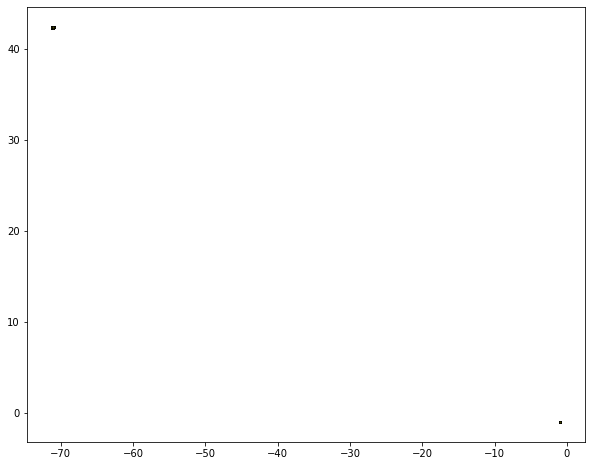

In [29]:
plt.figure(num = None, figsize = (10, 8))

plt.scatter("Long", "Lat", data = crime_assault, c = 'y', alpha = 0.5, edgecolor = 'black', s = 2)

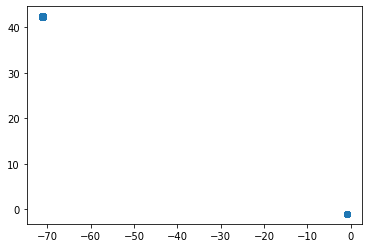

In [19]:
plt.scatter("Long", "Lat", data = crimedf)

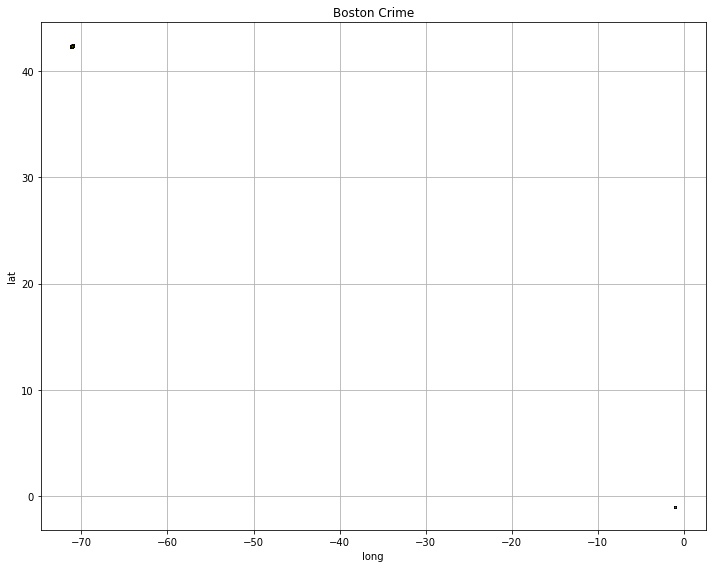

In [13]:
plt.grid()
plt.xlabel('long')
plt.ylabel('lat')
plt.title('Boston Crime')
plt.tight_layout()
plt.axis('tight')

plt.show()

In [5]:
map = folium.Map(location = boston_coords, zoom_start = 12)

In [6]:
map

In [7]:
crimedf_19 = crimedf[ crimedf['YEAR'] == 2019 ]

In [8]:
crimedf_19

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
1,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"
2,I192082680,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,794,NaN,2019-10-12 15:12:43,2019,10,Saturday,15,Part One,ALLSTON ST,42.352375,-71.135096,"(42.35237455, -71.13509584)"
3,I192082577,724,Auto Theft,AUTO THEFT,D4,130,NaN,2019-10-12 04:41:52,2019,10,Saturday,4,Part One,SAINT JAMES AVE,42.349476,-71.076402,"(42.34947586, -71.07640150)"
4,I192079582,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,A15,47,NaN,2019-10-02 08:08:49,2019,10,Wednesday,8,Part One,N MEAD ST,42.381846,-71.066551,"(42.38184582, -71.06655134)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426833,I020695210-00,1843,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,A1,77,NaN,2019-05-23 09:00:00,2019,5,Thursday,9,Part Two,NEW SUDBURY ST,42.361839,-71.059765,"(42.36183857, -71.05976489)"
426834,I020691165-00,3125,Warrant Arrests,WARRANT ARREST,A1,77,NaN,2019-05-23 08:00:00,2019,5,Thursday,8,Part Three,NEW SUDBURY ST,42.361839,-71.059765,"(42.36183857, -71.05976489)"
426835,I020674147-00,3125,Warrant Arrests,WARRANT ARREST,A1,77,NaN,2019-05-23 08:00:00,2019,5,Thursday,8,Part Three,NEW SUDBURY ST,42.361839,-71.059765,"(42.36183857, -71.05976489)"
426836,I020669075-00,3125,Warrant Arrests,WARRANT ARREST,A1,77,NaN,2019-05-23 08:00:00,2019,5,Thursday,8,Part Three,NEW SUDBURY ST,42.361839,-71.059765,"(42.36183857, -71.05976489)"


In [33]:
crimedf_19.describe()

NameError: name 'crimedf_19' is not defined

In [20]:
maxrows = 2000

map = folium.Map(location = boston_coords, zoom_start = 12)

for each in crimedf_19[0:maxrows].iterrows():
    MarkerCluster(
        location = [each[1]['Lat'],each[1]['Long']], Cluster = True)

In [28]:
m = folium.Map(
    location=[46.1991, -122.1889],
    tiles='Stamen Terrain',
    zoom_start=13
)

m.add_child(folium.LatLngPopup())

m

In [21]:
display(map)

In [ ]:
# group by neighborhood
boston = crime_input.groupby('PdDistrict').count()
sf = pd.DataFrame(sf,columns=['Category'])  # remove unneeded columns
sf.reset_index(inplace=True)   # default index, otherwise groupby column becomes index
sf.rename(columns={'PdDistrict':'Neighborhood','Category':'Count'}, inplace=True)
sf.sort_values(by='Count', inplace=True, ascending=False)
#print(sf)

# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42
sf_neighborhood_geo = '../datasets/san-francisco.geojson'

# Create map
sf_map = folium.Map(
       location=[latitude,longitude],
       zoom_start=12)

# Use json file  TEST based on class
sf_map.choropleth(
       geo_data=sf_neighborhood_geo,
       data=sf,
       columns=['Neighborhood','Count'],
       key_on='feature.properties.DISTRICT',
       fill_color='YlOrRd',
       fill_opacity='0.7',
       line_opacity='0.2',
       legend_name='Crime Rate in San Francisco, by Neighborhood')

# display the map
sf_map